In [1]:
import numpy as np
import pandas as pd

In [2]:
mks = pd.read_csv("data/MKS.csv")

In [3]:
#data preprocessing 
#remove NaN values
nans = mks[mks['Close'].isnull()]
mks.drop(nans.index, inplace=True) 

In [4]:
# Initialize a data frames to hold the Features and the value
X_len = 940
days = 10

Χ_columns = []
for j in range(days):
    Χ_columns.append('i+%s' % str(j))
    
X = pd.DataFrame(index=range(X_len),columns = Χ_columns)
y = pd.DataFrame(index=range(X_len), columns = ['Close'])

    
for i in range(X_len):
    for j in range(days):
        X.iloc[i]['i+%s' % str(j)] = mks.iloc[i + j]['Close']
    y.iloc[i] = mks.iloc[(i + j + 1)]['Close']
    
v = pd.concat([X, y], axis=1)
v.head()

,i+0,i+1,i+2,i+3,i+4,i+5,i+6,i+7,i+8,i+9,Close
0,459.8,469.9,471.6,461.9,452.9,453.3,456,442,435.5,426.7,416.6
1,469.9,471.6,461.9,452.9,453.3,456,442,435.5,426.7,416.6,427.7
2,471.6,461.9,452.9,453.3,456,442,435.5,426.7,416.6,427.7,434.5
3,461.9,452.9,453.3,456,442,435.5,426.7,416.6,427.7,434.5,442.3
4,452.9,453.3,456,442,435.5,426.7,416.6,427.7,434.5,442.3,440.2


In [5]:
dv = pd.DataFrame(index=range(X_len), columns = ['dv'])
dv.iloc[0] = 0
for i in range(1, X_len):
    dv.iloc[i] = mks.iloc[i]['Close'] - mks.iloc[i - 1]['Close']    
np.sqrt((dv ** 2).mean())

dv    6.778292
dtype: float64

In [6]:
def split_train_test_set(X, y, test_size=0.2):  
    # Train-test split
    if len(X) != len(y):
        return "Error"
    split_index = int(len(X) * (1-test_size))
    X_train = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]
    
    return X_train, X_test, y_train, y_test

In [7]:
# Import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

def rmsp(test, pred):
    return np.sqrt(np.mean(((test - pred)/test)**2)) * 100

def rmse(test, pred):
    return np.sqrt(((test - pred) ** 2).mean())

def print_metrics(test, pred):
    err = rmse(test, pred)
    print('RMSE %f'%  err)
    print('Root Mean Squared Percentage Error %f'% rmsp(test, pred))
    print('Mean Absolute Error: %f'% mean_absolute_error(test, pred))
    print('Explained Variance Score: %f'% explained_variance_score(test, pred))
    print('Mean Squared Error: %f'% mean_squared_error(test, pred))
    print('R2 score: %f'% r2_score(test, pred))
    print('')
    return err


def create_cv_sets(n_splits, size):
    cv_sets = []
    for index in range(n_splits):
        X_train, X_test, y_train, y_test = split_train_test_set(X[index:index + size], y[index:index + size])    
        cv_sets.append([X_train, X_test, y_train, y_test])
    return cv_sets 
n_splits = 3
size =310
cv_sets = create_cv_sets(n_splits, size)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV
def fit_model(X, y):
    regressor = LinearRegression()
    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    grid = GridSearchCV(regressor, parameters)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [9]:
regressors = []
errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    regressor = fit_model(X_train, y_train)
    regressors.append(regressor)
    pred = regressor.predict(X_test)
    #print("X_train.head(): ", X_train.head())
    #print("X_train.tail(): ", X_train.tail())
    #print("Pred: ", pred[:5])
    #print("Test: ", y_test[:5]) 
    #print(y_test['Close'])
    errs.append(print_metrics(y_test, pred))

RMSE 6.655403
Root Mean Squared Percentage Error 1.197290
Mean Absolute Error: 4.951782
Explained Variance Score: 0.833893
Mean Squared Error: 44.294394
R2 score: 0.826694

RMSE 6.700743
Root Mean Squared Percentage Error 1.206829
Mean Absolute Error: 4.991199
Explained Variance Score: 0.847973
Mean Squared Error: 44.899962
R2 score: 0.838626

RMSE 6.903192
Root Mean Squared Percentage Error 1.245639
Mean Absolute Error: 5.106675
Explained Variance Score: 0.837908
Mean Squared Error: 47.654056
R2 score: 0.832988



In [10]:
import matplotlib.pyplot as plt

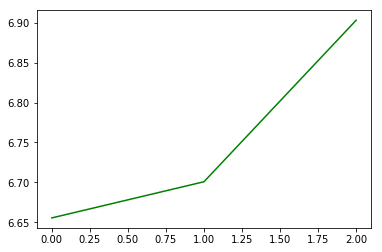

In [11]:
t = range(n_splits)
plt.plot(t, errs, 'g', label='Prediction')
plt.show()

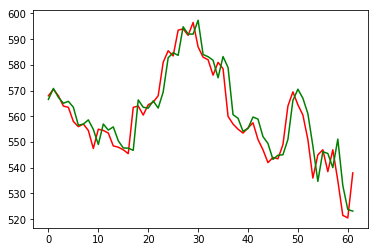

In [12]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, regressors[0].predict(X_test), 'g', label='Prediction')
plt.show()

In [13]:
regressors[0].coef_

array([[ 0.07785975, -0.02334136, -0.02546941, -0.032437  ,  0.17441355,
        -0.15248721, -0.11303175,  0.13307402, -0.10096956,  1.06377671]])

In [14]:
from sklearn.linear_model import Ridge 

def ridge(X_train, X_test, y_train, y_test):
    reg = Ridge()
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    #print("Pred: ", pred[:5])
    #print("Test: ", y_test[:5])
    print_metrics(y_test.values, pred)
    return rmse(y_test.values, pred), reg

In [15]:
enregs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    enregs.append(ridge(X_train,X_test,y_train,y_test)[1])
    

RMSE 6.860203
Root Mean Squared Percentage Error 1.235944
Mean Absolute Error: 5.246640
Explained Variance Score: 0.832478
Mean Squared Error: 47.062381
R2 score: 0.815864

RMSE 7.016969
Root Mean Squared Percentage Error 1.266062
Mean Absolute Error: 5.436225
Explained Variance Score: 0.846488
Mean Squared Error: 49.237851
R2 score: 0.823035

RMSE 7.080446
Root Mean Squared Percentage Error 1.278938
Mean Absolute Error: 5.382244
Explained Variance Score: 0.836792
Mean Squared Error: 50.132723
R2 score: 0.824301



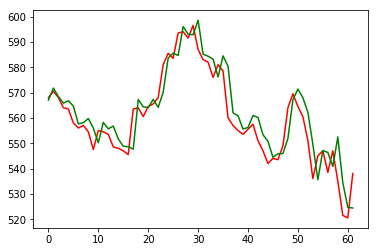

In [16]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, enregs[1].predict(X_test), 'g', label='Prediction')
plt.show()

In [17]:
enregs[1].coef_

array([[ 0.07926718, -0.01637378, -0.02187429, -0.02902184,  0.16766987,
        -0.17070296, -0.08730867,  0.13424622, -0.10518672,  1.05964239]])

In [18]:
from sklearn.svm import LinearSVR
def svr(X_train, X_test, y_train, y_test):
    # Classify and predict
    reg = LinearSVR()
    reg.fit(X_train, y_train.values.ravel())
    pred = reg.predict(X_test)

    #print("Pred: ", pred[:5])
    #print("Test: ", y_test[:5])

    print_metrics(y_test.values.ravel(), pred)
    return rmse(y_test.values.ravel(), pred), reg

In [19]:
svrs=[]
for X_train, X_test, y_train, y_test in cv_sets: 
    svrs.append(svr(X_train,X_test,y_train,y_test)[1])

RMSE 6.696865
Root Mean Squared Percentage Error 1.197132
Mean Absolute Error: 4.911839
Explained Variance Score: 0.826973
Mean Squared Error: 44.848001
R2 score: 0.824528

RMSE 9.550629
Root Mean Squared Percentage Error 1.727427
Mean Absolute Error: 8.140013
Explained Variance Score: 0.843318
Mean Squared Error: 91.214519
R2 score: 0.672167

RMSE 7.662953
Root Mean Squared Percentage Error 1.367999
Mean Absolute Error: 5.869612
Explained Variance Score: 0.834792
Mean Squared Error: 58.720852
R2 score: 0.794203



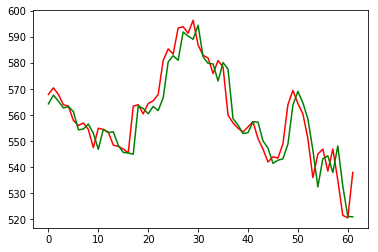

In [20]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, svrs[0].predict(X_test), 'g', label='Prediction')
plt.show()

In [21]:
last = np.array([310.5,312.5, 313.5,316.200012,316.299988,314.799988,316.100006,320.5,308.79998,308.700012]).reshape(1,-1)
pred = regressor.predict(last)
pred

array([[310.04679379]])

In [22]:
last = np.array([316.200012, 316.299988,314.799988,316.100006,320.5,308.799988,313.700012,310.80,318.30,324.00]).reshape(1,-1)
pred = regressor.predict(last)
pred


array([[326.50772764]])

In [23]:
from sklearn.externals import joblib
joblib.dump(regressors[0], 'prediction_model.pkl') 

['prediction_model.pkl']